In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import string 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from deep_translator import GoogleTranslator
import wordcloud
import spacy
nlp = spacy.load('en_core_web_sm')
import re
import warnings 
warnings.filterwarnings('ignore')

# LOAD THE DATASET 

In [2]:
df=pd.read_excel('P597 DATASET.xlsx')

In [3]:
# combining title and body columns 
df['text'] = df['title']+ ' ' + df['body']
df.drop(columns=['title','body'],inplace=True)

In [4]:
df.isnull().sum()

rating    0
text      0
dtype: int64

In [5]:
df.head()

,rating,text
0,1,Horrible product Very disappointed with the ov...
1,3,Camera quality is not like 48 megapixel Camera...
2,4,"Overall Got the mobile on the launch date,Batt..."
3,1,A big no from me 1. It doesn't work with 5.0GH...
4,1,Put your money somewhere else Not worth buying...


In [6]:
df.shape

(1440, 2)

# DATA CLEANING

In [7]:
custom_stopwords = nlp.Defaults.stop_words.copy()
custom_stopwords = custom_stopwords.difference({
    "not", "no", "nor", "never", "none", "nobody", "nothing", "nowhere"})

In [8]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.translator = GoogleTranslator(source='auto', target='en')

    def translate_to_english(self, text):
        try:
            if pd.isnull(text) or str(text).strip() == "":
                return ""
            return self.translator.translate(text)
        except Exception:
            return text

    def clean_text(self, text):
        # Keep only words
        text1 = ' '.join(re.findall(r'\w+', str(text)))
        doc = nlp(text1)
        clean_data = [
            token.lemma_ for token in doc
            if token.text.lower() not in custom_stopwords
            and not token.is_punct
            and not token.is_digit
            and not token.is_bracket
            and not token.is_currency
        ]
        return ' '.join(clean_data)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Step 1: translate each text
        X_translated = X.apply(self.translate_to_english)
        # Step 2: clean & lemmatize
        X_cleaned = X_translated.apply(self.clean_text)
        return X_cleaned

In [9]:
cleaner = TextPreprocessor()

# Intialize sentiment analyzer(VADER)

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [11]:
sia = SentimentIntensityAnalyzer()

In [12]:
df['clean_text'] = cleaner.transform(df['text'])
df['sentiment_score'] = df['clean_text'].apply(lambda x : sia.polarity_scores(x)['compound'])

In [13]:
# converting sentiment score to labels :
df['sentiment']=df['sentiment_score'].apply(lambda x: 'positive' if x>0.05 else ('negative' if x<-0.05 else 'neutral'))

In [14]:
df = df[['rating', 'text', 'clean_text', 'sentiment_score','sentiment']]
df.head()

,rating,text,clean_text,sentiment_score,sentiment
0,1,Horrible product Very disappointed with the ov...,horrible product disappointed overall performa...,-0.7650,negative
1,3,Camera quality is not like 48 megapixel Camera...,camera quality not like megapixel Camera quali...,-0.4956,negative
2,4,"Overall Got the mobile on the launch date,Batt...",Overall get mobile launch date Battery appreci...,0.2023,positive
3,1,A big no from me 1. It doesn't work with 5.0GH...,big no doesn t work 0ghz WiFi frequency 4GHz o...,-0.7906,negative
4,1,Put your money somewhere else Not worth buying...,money not worth buy faulty software poor displ...,-0.1788,negative


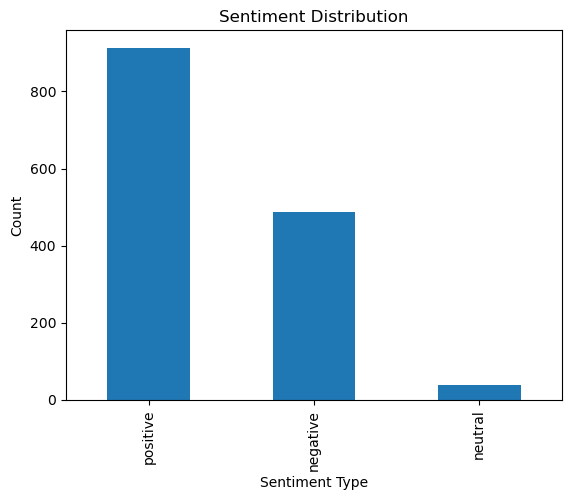

In [15]:
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Type')
plt.ylabel('Count')
plt.show()

In [16]:
feature = df[['clean_text']] 
target = df['sentiment']

In [17]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(feature,target,random_state=42,test_size=0.2)

# RANDOM OVER SAMPLER

In [18]:
# randomoversampler is used to balance the dataset
from imblearn.over_sampling import RandomOverSampler

# create oversampler
ros = RandomOverSampler(random_state=42)

x_train_res, y_train_res = ros.fit_resample(x_train, y_train)


In [19]:
# balanced for only training data 
balanced_df = pd.concat([x_train_res,y_train_res],axis=1)
balanced_df.head()

,clean_text,sentiment
0,excellent product like product battery life fi...,positive
1,minor lag UI Noticed device awesome u get mine...,negative
2,think phone worth purchaseand good budget prom...,positive
3,value money Superb great speed photo clarity L...,positive
4,pay Good no regret s worth pay Happy camera ba...,positive


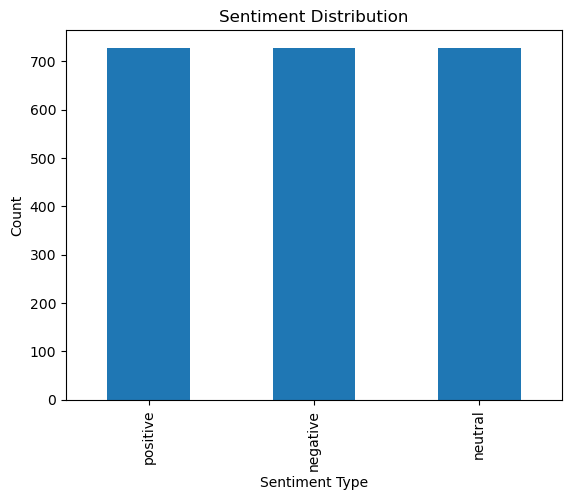

In [20]:
balanced_df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Type')
plt.ylabel('Count')
plt.show()

In [21]:
# converting text to numerical form 
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(balanced_df['clean_text'])
x_test_tfidf = tfidf.transform(x_test['clean_text']) 

In [22]:
from sklearn.metrics import accuracy_score, classification_report

In [23]:
# Multi Nomial NB
from sklearn.naive_bayes import MultinomialNB
multi = MultinomialNB()
multi.fit(x_train_tfidf,y_train_res.values.ravel())

MultinomialNB()

In [24]:
y_pred = multi.predict(x_test_tfidf)

In [25]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

    negative       0.71      0.75      0.73        95
     neutral       0.08      0.12      0.10         8
    positive       0.88      0.83      0.86       185

    accuracy                           0.78       288
   macro avg       0.56      0.57      0.56       288
weighted avg       0.80      0.78      0.79       288



In [26]:
#logistic regreession
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=10,max_iter=100,solver='liblinear')
log.fit(x_train_tfidf,y_train_res)

LogisticRegression(C=10, solver='liblinear')

In [27]:
y_pred = log.predict(x_test_tfidf)

In [28]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

    negative       0.85      0.76      0.80       107
     neutral       0.12      0.50      0.20         2
    positive       0.88      0.91      0.89       179

    accuracy                           0.85       288
   macro avg       0.62      0.72      0.63       288
weighted avg       0.86      0.85      0.85       288



In [29]:
from sklearn.model_selection import GridSearchCV
params = {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }

In [30]:
grid = GridSearchCV(log,params)
grid.fit(x_train_tfidf,y_train_res)

GridSearchCV(estimator=LogisticRegression(C=10, solver='liblinear'),
             param_grid={'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']})

In [31]:
grid.best_params_

{'C': 10, 'solver': 'liblinear'}

In [32]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('cleaner',TextPreprocessor()),
    ('tfidf', tfidf),
    ('clf', log)
])

In [33]:
pipeline

Pipeline(steps=[('cleaner', TextPreprocessor()), ('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10, solver='liblinear'))])

In [34]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    df['text'], df['sentiment'], test_size=0.2, random_state=42)


In [35]:
pipeline.fit(x_train,y_train)

Pipeline(steps=[('cleaner', TextPreprocessor()), ('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(C=10, solver='liblinear'))])

In [36]:
y_pred = pipeline.predict(x_test)

In [37]:
print(accuracy_score(y_pred,y_test))

0.8506944444444444


In [38]:
import pickle
file = "nlp.pkl"
pickle.dump(pipeline,open(file,"wb"))